# Decision Trees
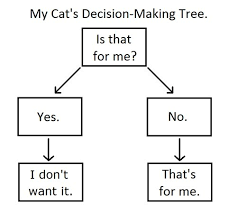

A decision tree is a tree-like graph with nodes representing the place where we pick an attribute and ask a question. Edges represent the answers to the question, leaves -- the actual output or class label. Decision trees are:
<ul><li><b>greedy</b> because at each step we pick the best split possible  <li><b>top-down</b> because we start with the root node
    </ul>

In chemistry a good example of a decision tree would be identifying cations or categorizing organic substances:

#### Decision Tree in Analytics
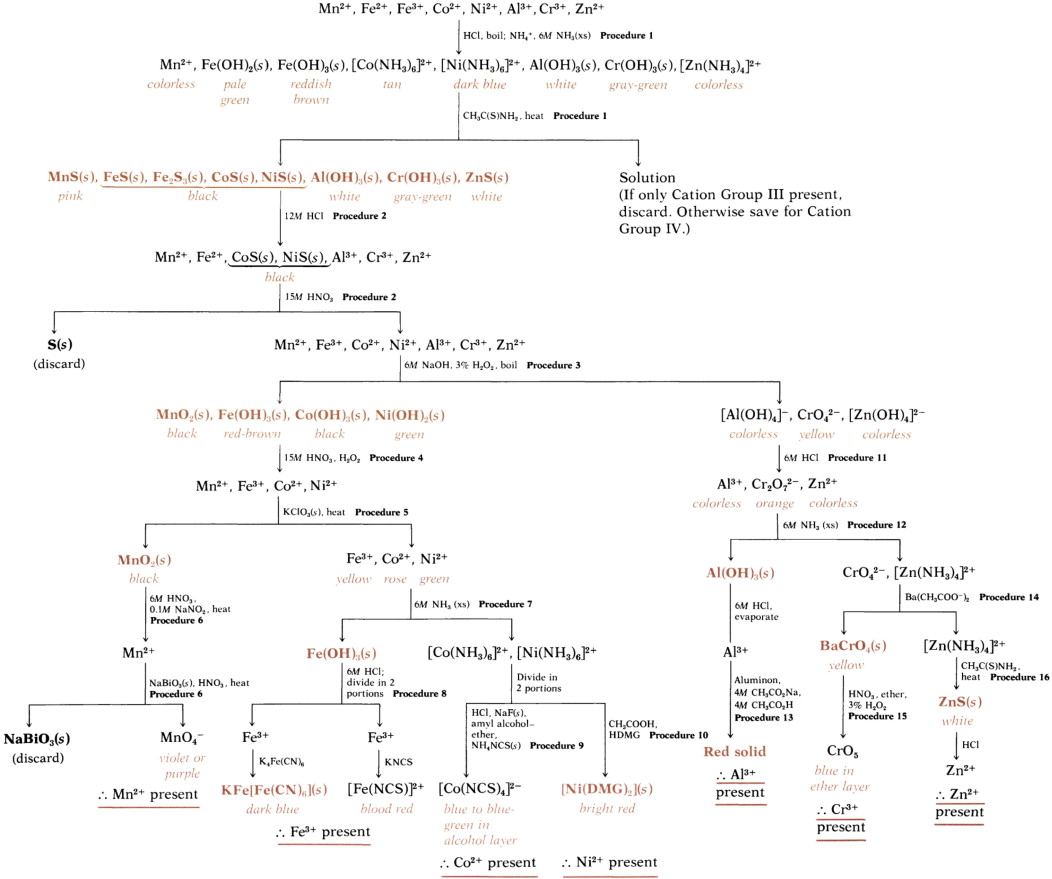

#### Decision Tree in Organics
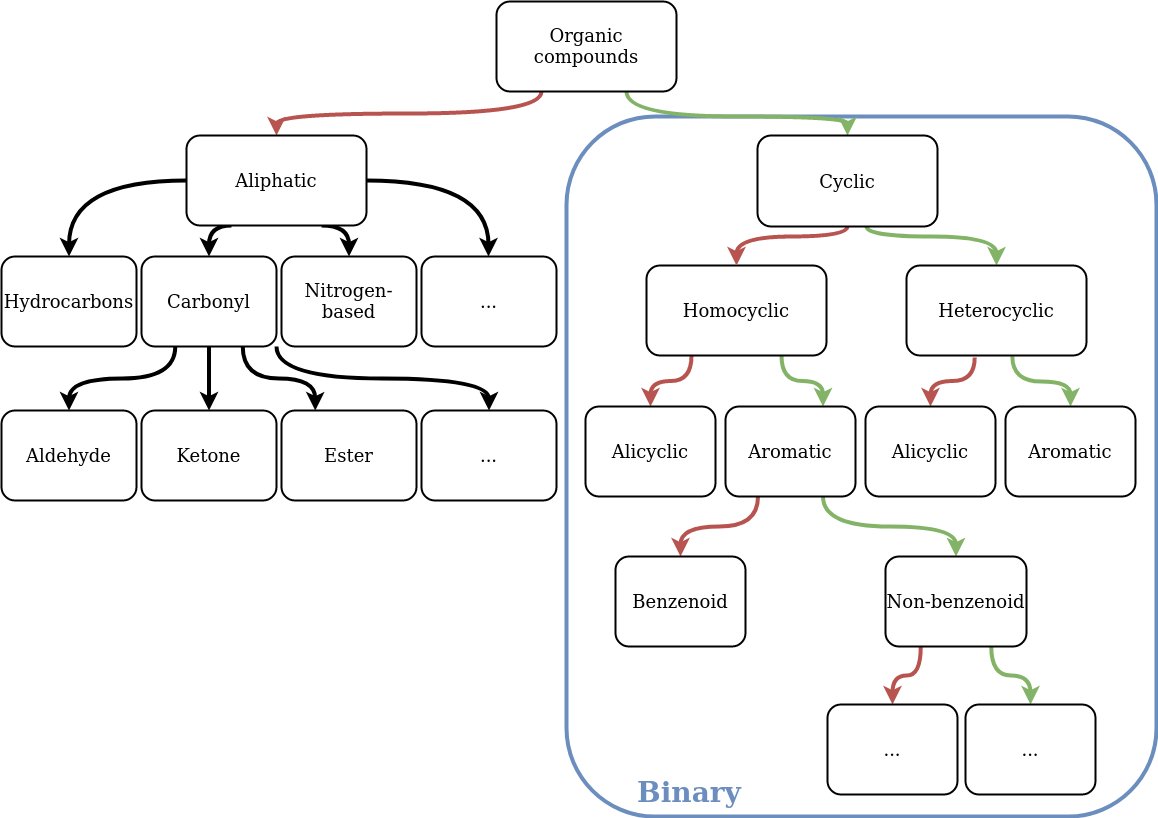

Trees cover both classification and regression

Todo: Cover trees algorithms: CART, etc

Decision trees is a complex topic. We'll start with some simple example on desiding whether this or that element of the periodic system is a metal

## Finding Metals using Decision Trees

We'll import all necessary libraries

In [1]:
import pandas as pd
import math
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pydotplus
from IPython.display import Image

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import BayesianRidge

warnings.filterwarnings('ignore')

When we make decisions using trees, we depend on logic. The core of machine logic is calculating entropy, not the thermochemical one though. It still can be described as the degree of chaos in the system -- the higher the entropy, the less ordered the system and vice versa. Shannon's entropy is defined for a system with N possible states as follows:

$$\Large S = -\sum_{i=1}^{N}p_i \log_2{p_i},$$
<br>$p_i$ is the probability of finding the system in the $i$-th state.

In [2]:
def calculate_entropy(a,b, _sum=None):
    if _sum is None:
        _sum = a+b
    return calculate_entropy_summand(a, _sum)+calculate_entropy_summand(b, _sum)

def calculate_entropy_summand(a, b):
    return -a/b*math.log(a/b,2)

Below are the first elements of the periodic system. Our task is knowing only the atomic number predict if the element chosen is a metal. For this reason, we'll calculate entropy for each position and will split wherever it is the highest.
<br>
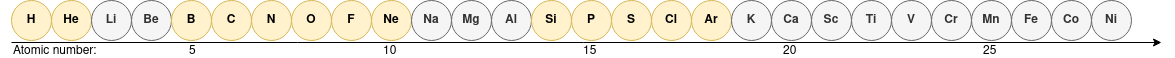
<br>

There are 13 non-metallic and 15 metallic elements. If we randomly select an element, the probability of it being  non-metallic $p_1=\frac{13}{28}$, and $p_2=\frac{15}{28}$ it being metallic, which gives us an entropy $S_0 = -\frac{13}{28}\log_2{\frac{13}{28}}-\frac{15}{28}\log_2{\frac{15}{28}} \approx 1$.

In [3]:
print(-13/28*math.log(13/28,2)-15/28*math.log(15/28,2))
print(calculate_entropy(13,15))

0.996316519558962
0.996316519558962


This value by itself may not tell us much, but let's see how the value changes if we were to break the balls into two equal groups, divinding the set by position 14. We'll have 9 non-metals + 5 metals in the 1st group and 4 non-metals with 10 metals in the 2nd group. 


The entropy for the first 14 elements - $S_1$:

In [4]:
print(calculate_entropy(9,5))

0.9402859586706309


The entropy for elements 15-28 - $S_2$:

In [5]:
print(calculate_entropy(4,10))

0.863120568566631


Entropy has decreased in both groups. The reduction in entropy is called information gain, since entropy is the degree of uncertainty. The information gain (IG) can be calculated as initial entropy minus fractions of gaine entropies:
$$ \Large IG(x \leq 14) = S_0 - \frac{14}{28}S_1 - \frac{14}{28}S_2 = 0.996 -  \frac{1}{2}0.94 -  \frac{1}{2}0.863 \approx 0.095.$$

In [6]:
calculate_entropy(13,15)-0.5*calculate_entropy(9,5)-0.5*calculate_entropy(4,10)

0.0946132559403311

As, IG is positive, we got a more ordered system, than we had initially. Now it's time to perform all splittings and build the tree.
<br>*Give it a shot and guess where would've you splitted the set.*

#### Code part

We'll create a dataframe from our data

In [7]:
metal_df= pd.DataFrame(data=[0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1], columns=['is_metal'])

The following operations are written to calculate the entropy value for each element position. No need to dig and understand it in detail - all was explained above

In [8]:
#Step 1. Prepare index and filter columns
metal_df['position'] = metal_df.index+1
metal_df = metal_df[['position', 'is_metal']]

#Step 2. Calculate the number of metallic and non-metallic elements for each position starting from the first
_count, _nms, _ms = metal_df.shape[0], metal_df[metal_df['is_metal'] == 0].shape[0], metal_df[metal_df['is_metal'] == 1].shape[0]
_S0 = calculate_entropy(metal_df[metal_df['is_metal'] == 0].shape[0], metal_df[metal_df['is_metal'] == 1].shape[0])
metal_df['sum_metal'] = metal_df['is_metal'].cumsum()
metal_df['sum_non_metal'] = metal_df['position'] - metal_df['sum_metal']

#Step 3. Calculate entropy before and after the position, ant it's sum
metal_df['s1'] = metal_df.iloc[:-1].apply(lambda x: 0 if x.sum_metal==0 or x.sum_non_metal==0 
    else calculate_entropy(x.sum_metal, x.sum_non_metal), axis=1)

metal_df['s2'] = metal_df.iloc[:-1].apply(lambda x: 0 if x.sum_metal==_ms or x.sum_non_metal==_nms
    else calculate_entropy(_ms-x.sum_metal, _nms-x.sum_non_metal), axis=1)

metal_df['dS'] = _S0 - metal_df['position']/_count*metal_df['s1'] - (_count-metal_df['position'])/_count*metal_df['s2']

Max information gained at position 18


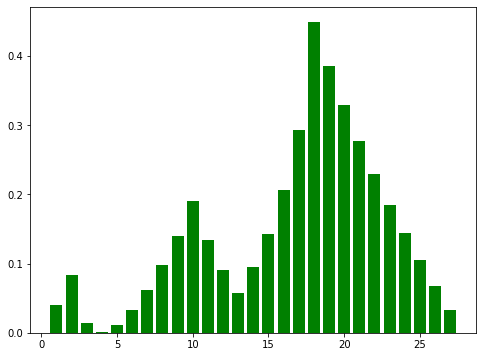

In [9]:
plt.figure(figsize=(8,6))
plt.bar(metal_df['position'], metal_df['dS'], color = 'green')
print('Max information gained at position {0}'.format(int(metal_df.loc[metal_df['dS'].idxmax(axis = 0)]['position'])))

It seems that the best splitting is to separate the last 10 metal elements. Seems logical. Now we'll perform the same operation till we have all separate classes

<b>Classifing if an element is metal by it's position in the periodic system</b>
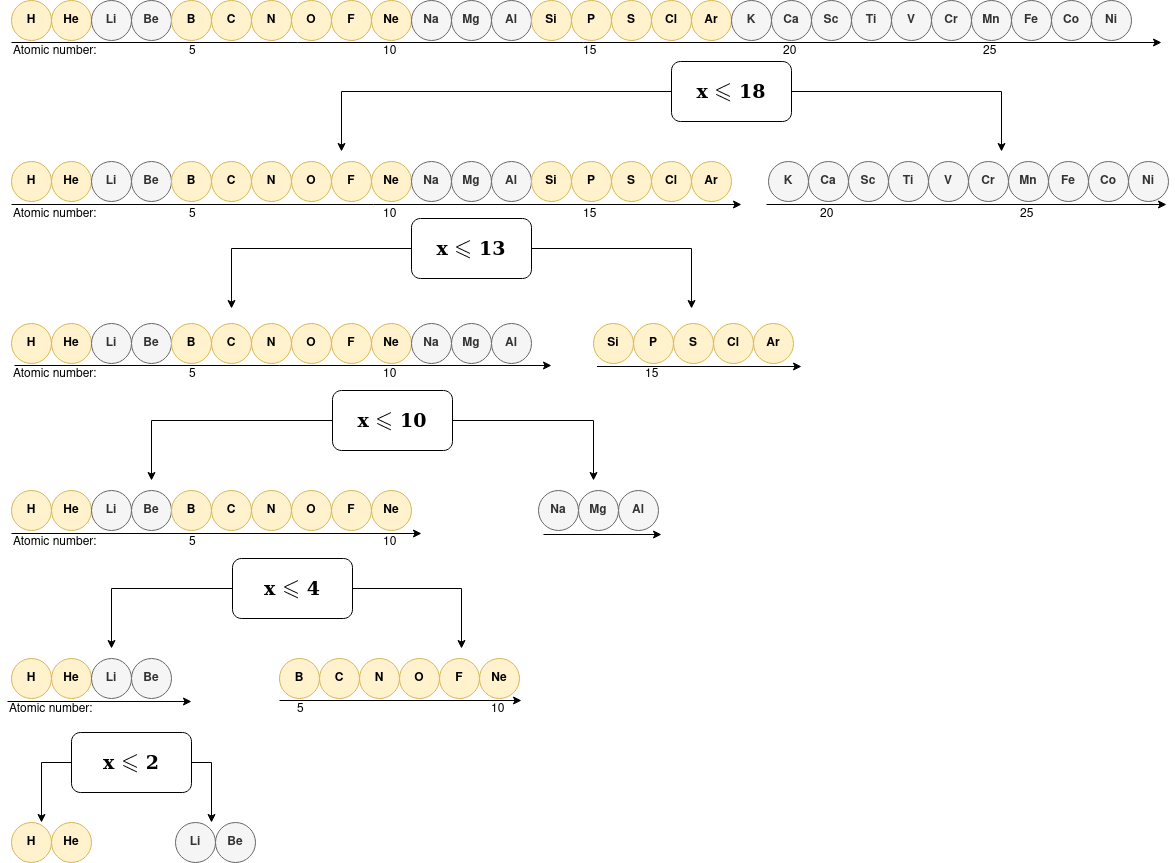

This might look weird. In order to fully separate our 6 groups we need only `math.ceil(math.log(6,2)) == 3` separations. But we have 5!
<br>Think of it as a game of 20 questions. The only difference of <i>entropy-driven</i> game is you don't know how many questions you have, and after each one you might be stopped.
<br>In the next example, the element property won't be structured, so we'll see a more normal-looking tree

## Finding Allotrope Elements using Decision Trees

I'll give you the calculated tree right away.

<b>Decision Tree if an element has allotropic modifications based on it's position in the periodic system</b>
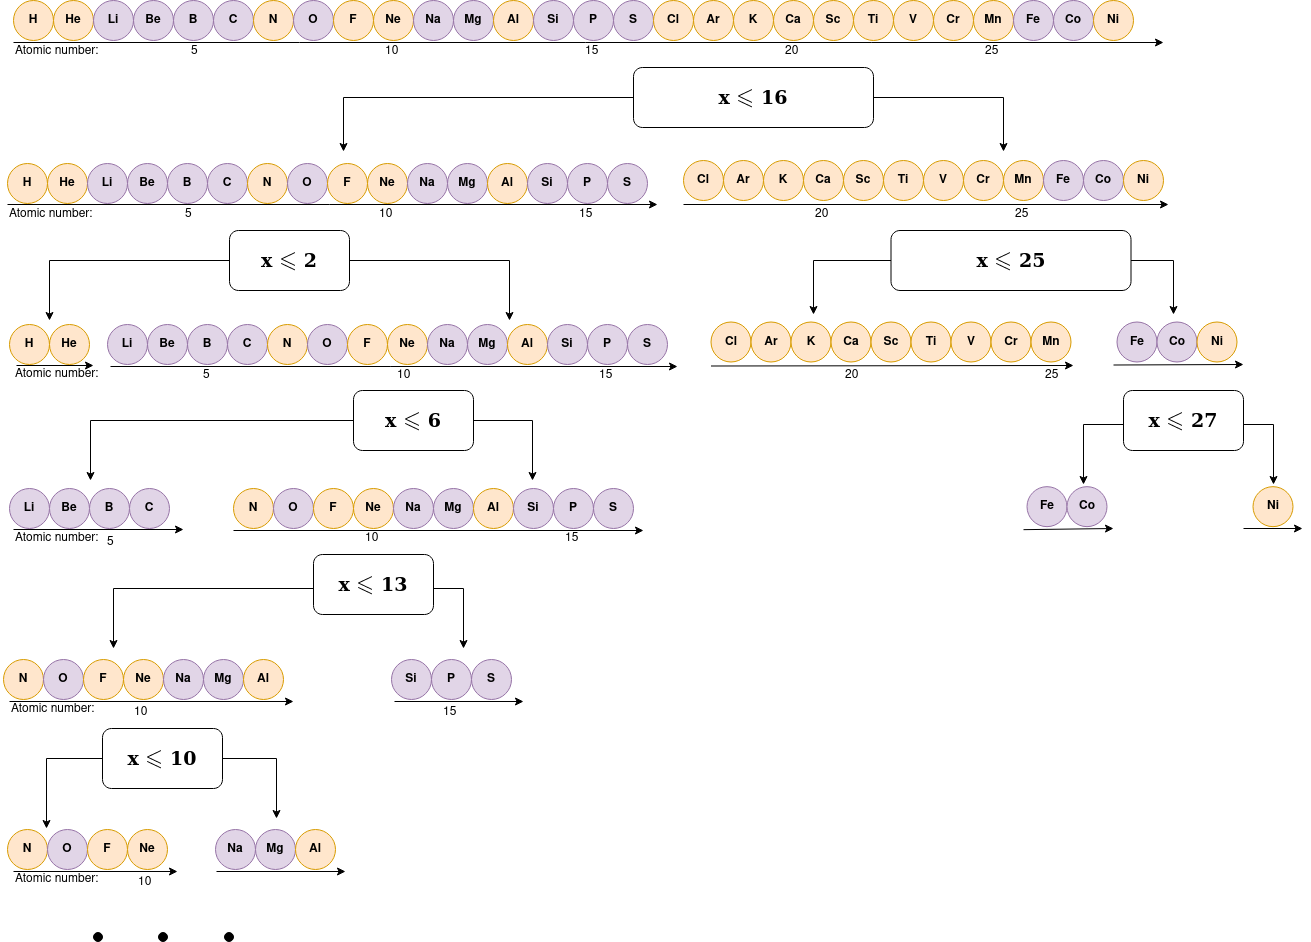

The following operations are written to calculate the entropy value for each element position and are the same as the ones we used for metal-decisioning. No need to dig and understand it in detail - all was explained above

In [10]:
al_df= pd.DataFrame(data=[0,0,1,1,1,1,0,1,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0], columns=['is_allotropic'])
al_df['position'] = al_df.index+1
al_df = al_df[['position', 'is_allotropic']]
_count, _nals, _als = al_df.shape[0], al_df[al_df['is_allotropic'] == 0].shape[0], al_df[al_df['is_allotropic'] == 1].shape[0]
_S0 = calculate_entropy(al_df[al_df['is_allotropic'] == 0].shape[0], al_df[al_df['is_allotropic'] == 1].shape[0])

al_df['sum_allotropic'] = al_df['is_allotropic'].cumsum()
al_df['sum_non_allotropic'] = al_df['position'] - al_df['sum_allotropic']

al_df['s1'] = al_df.iloc[:-1].apply(lambda x: 0 if x.sum_allotropic==0 or x.sum_non_allotropic==0 
    else calculate_entropy(x.sum_allotropic, x.sum_non_allotropic), axis=1)

al_df['s2'] = al_df.iloc[:-1].apply(lambda x: 0 if x.sum_allotropic==_als or x.sum_non_allotropic==_nals
    else calculate_entropy(_als-x.sum_allotropic, _nals-x.sum_non_allotropic), axis=1)

al_df['dS'] = _S0 - al_df['position']/_count*al_df['s1'] - (_count-al_df['position'])/_count*al_df['s2']

Now that we understand the basics, let's start using libraries. In the example below, we'll draw a decision tree using tree_graph_to_png and get_grid functions. To calculate the tree we'll use `DecisionTreeClassifier` from `sklearn.tree`. By setting `max_depth` parameter we decide where to prune the tree.
<br>*Q: Why do you think we need to prune trees?*

In [11]:
# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

def set_tree_params(criterion='entropy', max_depth=3):
    return DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                  random_state=17)

def tree_graph_to_png(tree, feature_names, png_file_to_save=None):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    if png_file_to_save:
        graph.write_png(png_file_to_save)
    return Image(graph.create_png(), width = 600, height = 300)

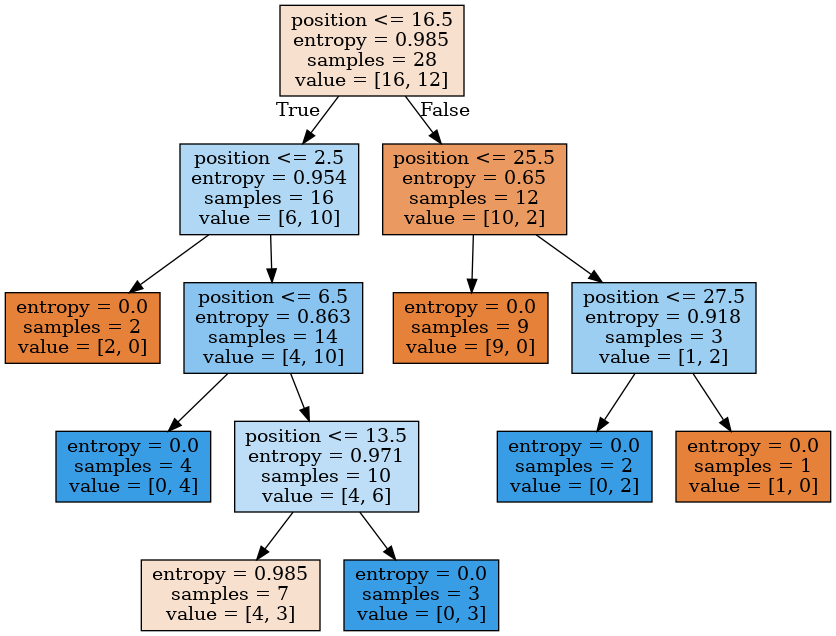

In [12]:
clf_tree = set_tree_params(max_depth=4)
clf_tree.fit(al_df['position'].to_numpy().reshape(-1, 1), al_df['is_allotropic'].to_numpy())
tree_graph_to_png(tree=clf_tree, feature_names=['position'])

This tree is a copycat of a tree we had above
<br> Now let's take a closer look to some real chem data. In our *Visual Data Analysis* lecture, we stored a `tsne.csv` file, representing the molecule chirality. We'll now build a chirality classifier for our molecules

## Building Chirality Classifier using Decision Trees

In [13]:
from numpy import genfromtxt
tsne_list = genfromtxt('../../tsne.csv', delimiter=',')
train_data = tsne_list[:,0:2]
train_labels = tsne_list[:,2]

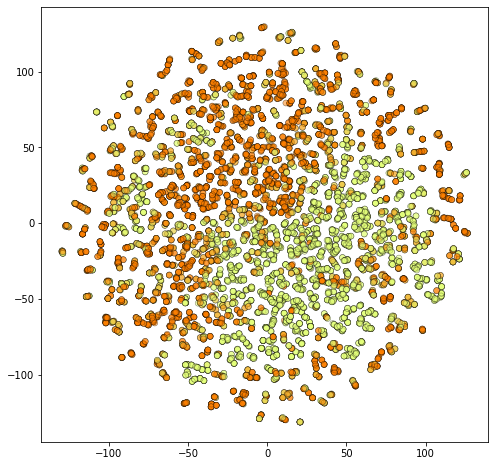

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(train_data[:, 0], train_data[:, 1],
            c=train_labels, alpha=.5, cmap = 'Wistia', edgecolors='black', linewidth=0.5);
plt.plot();

Let's visualize different max_depth parameters for our data:
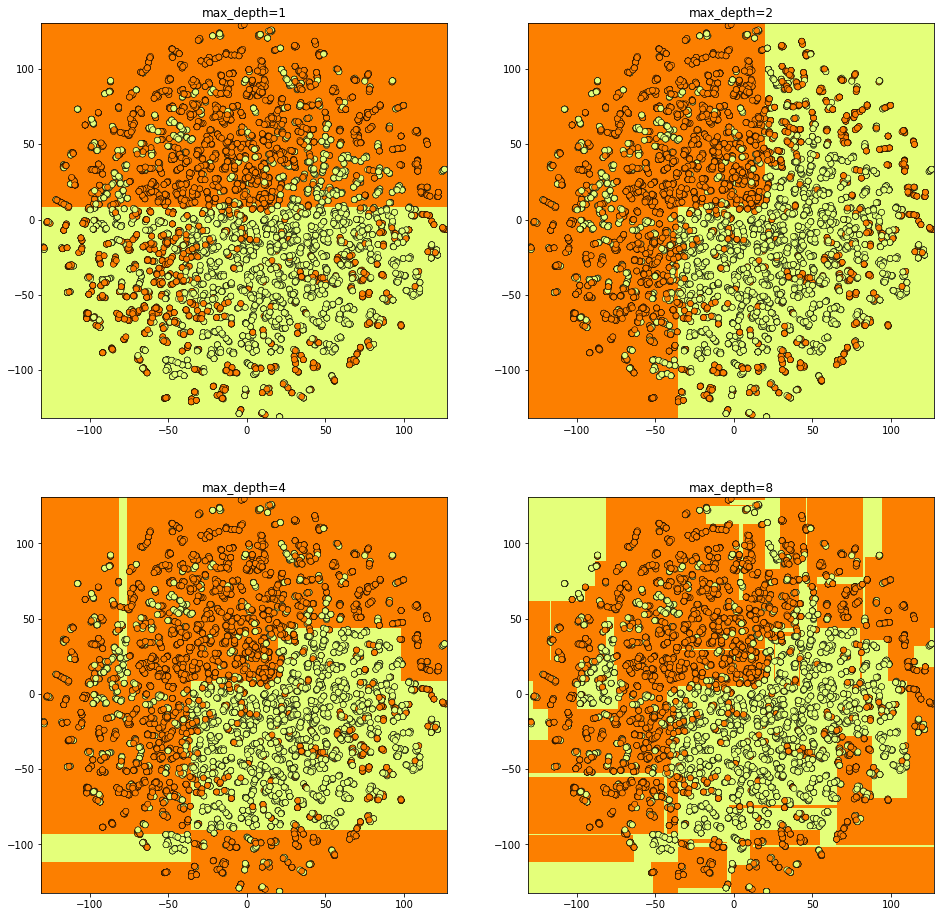

In [15]:
# The picture is inserted to save memory on your machine. 
# To reproduce this picture run the follwoing code for 1,2 or all 4 pics
'''
fig, axes = plt.subplots(2, 2, figsize=(16,16))
for i in range(4):
    clf_tree = set_tree_params(max_depth=2**i)
    clf_tree.fit(train_data, train_labels)
    xx, yy = get_grid(train_data)
    predicted = clf_tree.predict(np.c_[xx.ravel(), 
                                       yy.ravel()]).reshape(xx.shape)
    axes[i//2,i%2].pcolormesh(xx, yy, predicted, cmap='Wistia')
    axes[i//2,i%2].set_title('max_depth={0}'.format(2**i))
    axes[i//2,i%2].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
                cmap='Wistia', edgecolors='black', linewidth=0.5);
'''

"\nfig, axes = plt.subplots(2, 2, figsize=(16,16))\nfor i in range(4):\n    clf_tree = set_tree_params(max_depth=2**i)\n    clf_tree.fit(train_data, train_labels)\n    xx, yy = get_grid(train_data)\n    predicted = clf_tree.predict(np.c_[xx.ravel(), \n                                       yy.ravel()]).reshape(xx.shape)\n    axes[i//2,i%2].pcolormesh(xx, yy, predicted, cmap='Wistia')\n    axes[i//2,i%2].set_title('max_depth={0}'.format(2**i))\n    axes[i//2,i%2].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, \n                cmap='Wistia', edgecolors='black', linewidth=0.5);\n"

You can see how the classifier becomes more and more accurate. On the other hand, the overall picture seems to get more and more fragmentized, what eventually leads to overfitting. We can plot `max_depth` vs `accuracy`, to estimate the optimum `max_depth` value

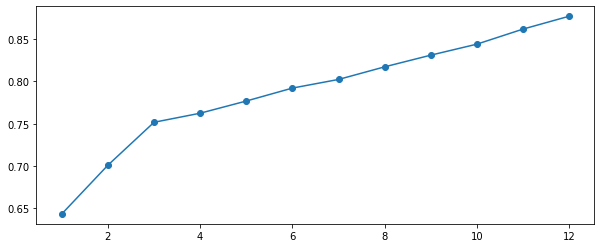

In [16]:
plt.figure(figsize=(10,4))
score_arr = []
for i in range(12):
    clf_tree = set_tree_params(max_depth=i+1)
    clf_tree.fit(train_data, train_labels)
    score_arr.append(clf_tree.score(train_data, train_labels))
plt.scatter([x+1 for x in range(12)], score_arr)
plt.plot([x+1 for x in range(12)], score_arr)

Fair to say `max_depth=3` seems as a solid choice

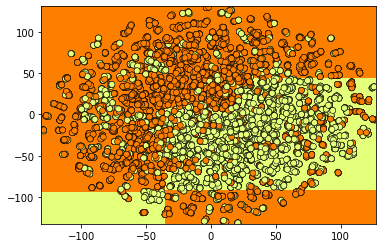

In [17]:
clf_tree = set_tree_params(max_depth=3)
clf_tree.fit(train_data, train_labels)
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='Wistia')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
            cmap='Wistia', edgecolors='black', linewidth=0.5);

Technically we can use a higher value of max_depth, but most probably it'll be partitions on less important features. Our goal is to avoid generating too specific rules for our model.
<br>There are exceptions, though. Trees are built to the maximum depth when a group of trees (random forest) responses are averaged or if you go from bottom up, some nodes may be removed comparing the quality gained by pruning a node

Besides `max_depth`, there are other important parameters, as `max_features` and `min_samples_leaf` in the [`sklearn.tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):
- `max_features` - the maximum number of features with which to search for the best partition (this is necessary with a large number of features because it would be "expensive" to search for partitions for *all* features);
- `min_samples_leaf` – the minimum number of samples in a leaf. This parameter prevents creating trees where any leaf would have only a few members.

# Predicting Biodegradation using Decision Trees

Time to make classification predictions!
<br>Let's take a look at a [biodegradation dataset](https://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation). We have 1055 samples and 41(!) columns, last being our target:
<br>1) SpMax_L: Leading eigenvalue from Laplace matrix
<br>2) J_Dz(e): Balaban-like index from Barysz matrix weighted by Sanderson electronegativity
<br>3) nHM: Number of heavy atoms
<br>4) F01[N-N]: Frequency of N-N at topological distance 1
<br>5) F04[C-N]: Frequency of C-N at topological distance 4
<br>6) NssssC: Number of atoms of type ssssC
<br>7) nCb-: Number of substituted benzene C(sp2)
<br>8) C%: Percentage of C atoms
<br>9) nCp: Number of terminal primary C(sp3)
<br>10) nO: Number of oxygen atoms
<br>11) F03[C-N]: Frequency of C-N at topological distance 3
<br>12) SdssC: Sum of dssC E-states
<br>13) HyWi_B(m): Hyper-Wiener-like index (log function) from Burden matrix weighted by mass
<br>14) LOC: Lopping centric index
<br>15) SM6_L: Spectral moment of order 6 from Laplace matrix
<br>16) F03[C-O]: Frequency of C - O at topological distance 3
<br>17) Me: Mean atomic Sanderson electronegativity (scaled on Carbon atom)
<br>18) Mi: Mean first ionization potential (scaled on Carbon atom)
<br>19) nN-N: Number of N hydrazines
<br>20) nArNO2: Number of nitro groups (aromatic)
<br>21) nCRX3: Number of CRX3
<br>22) SpPosA_B(p): Normalized spectral positive sum from Burden matrix weighted by polarizability
<br>23) nCIR: Number of circuits
<br>24) B01[C-Br]: Presence/absence of C - Br at topological distance 1
<br>25) B03[C-Cl]: Presence/absence of C - Cl at topological distance 3
<br>26) N-073: Ar2NH / Ar3N / Ar2N-Al / R..N..R
<br>27) SpMax_A: Leading eigenvalue from adjacency matrix (Lovasz-Pelikan index)
<br>28) Psi_i_1d: Intrinsic state pseudoconnectivity index - type 1d
<br>29) B04[C-Br]: Presence/absence of C - Br at topological distance 4
<br>30) SdO: Sum of dO E-states
<br>31) TI2_L: Second Mohar index from Laplace matrix
<br>32) nCrt: Number of ring tertiary C(sp3)
<br>33) C-026: R--CX--R
<br>34) F02[C-N]: Frequency of C - N at topological distance 2
<br>35) nHDon: Number of donor atoms for H-bonds (N and O)
<br>36) SpMax_B(m): Leading eigenvalue from Burden matrix weighted by mass
<br>37) Psi_i_A: Intrinsic state pseudoconnectivity index - type S average
<br>38) nN: Number of Nitrogen atoms
<br>39) SM6_B(m): Spectral moment of order 6 from Burden matrix weighted by mass
<br>40) nArCOOR: Number of esters (aromatic)
<br>41) nX: Number of halogen atoms
<br>42) experimental class: ready biodegradable (RB) and not ready biodegradable (NRB)

In [18]:
biodeg_df = pd.read_csv('../../data/biodeg.csv', delimiter=';', header=None)
biodeg_df.columns = columns=[x for x in range(1,43)]
print(biodeg_df[42].value_counts())
biodeg_df.head()

NRB    699
RB     356
Name: 42, dtype: int64


,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,RB
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,RB
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,RB
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,RB
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,RB


Stratified sampling, as `NRB` class is twice as big as `RB`

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(biodeg_df.drop([42], axis=1), biodeg_df[42], 
                                                    stratify=biodeg_df[42], test_size=0.20, random_state=1)

In [20]:
clf_tree = DecisionTreeClassifier(random_state = 1)
clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[123  17]
 [ 18  53]]
              precision    recall  f1-score   support

         NRB       0.87      0.88      0.88       140
          RB       0.76      0.75      0.75        71

    accuracy                           0.83       211
   macro avg       0.81      0.81      0.81       211
weighted avg       0.83      0.83      0.83       211



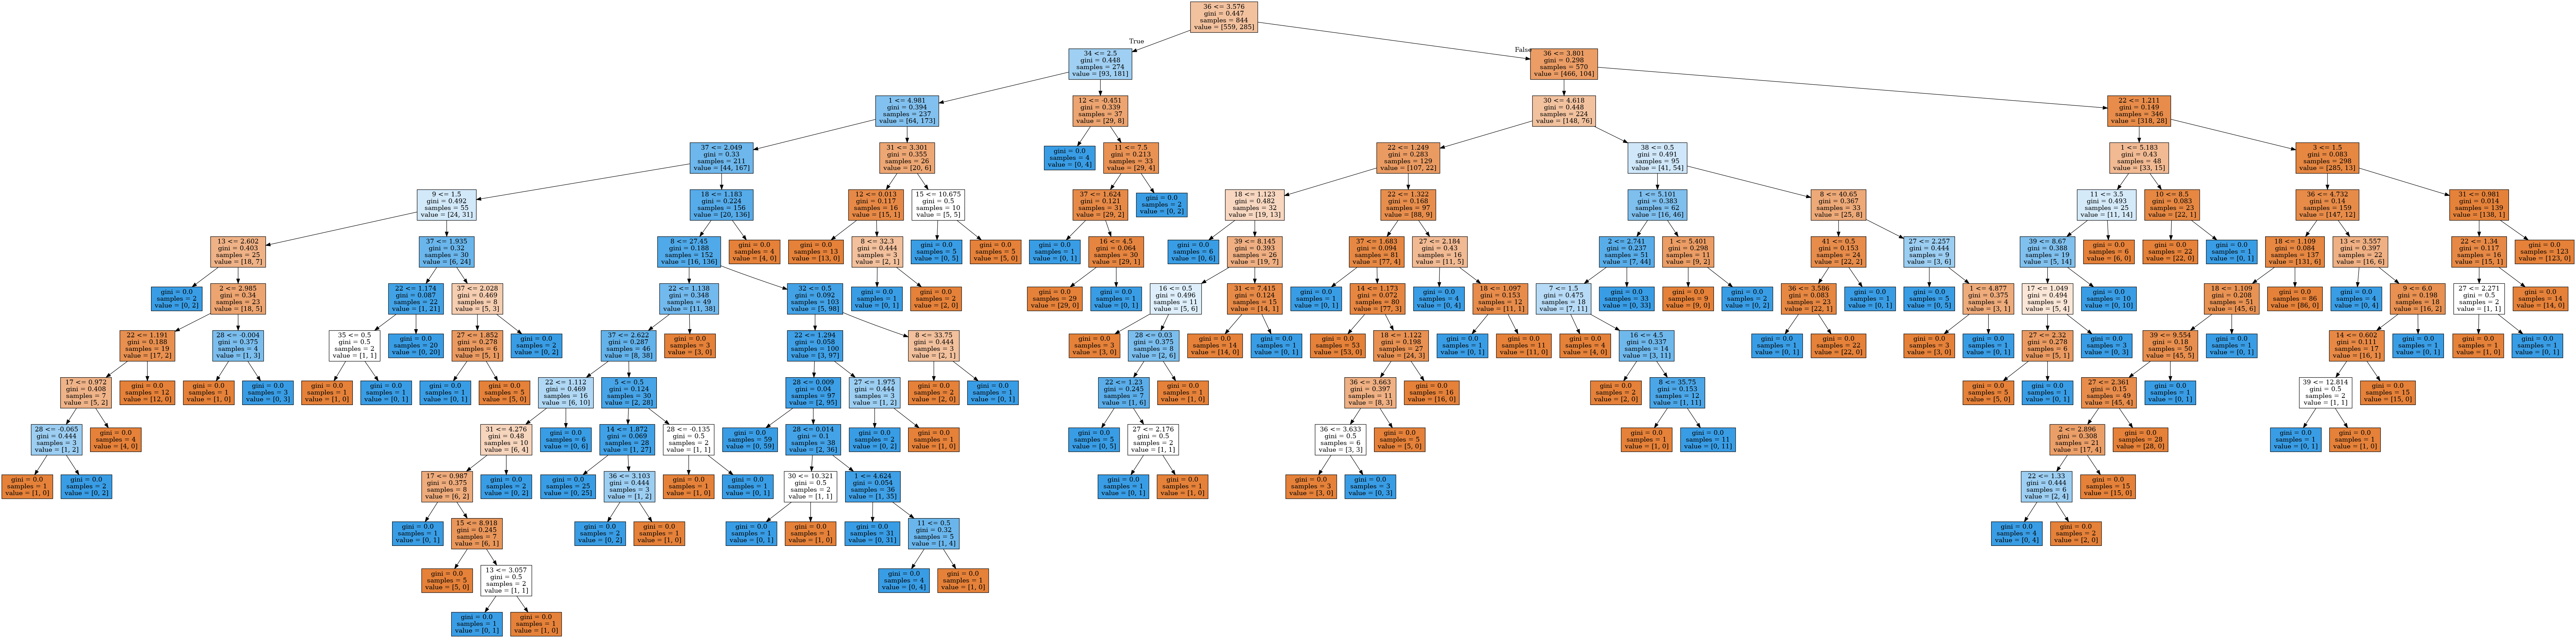

In [22]:
tree_graph_to_png(tree=clf_tree, feature_names=[x for x in range(1,42)])

Our straightforward out-of-the-box approach resulted in misclassifying `17+18 = 37` samples ot of 211. Not Bad for a start. The tree itself is quite large and might be overfitted. Let's see what happens when we prune it

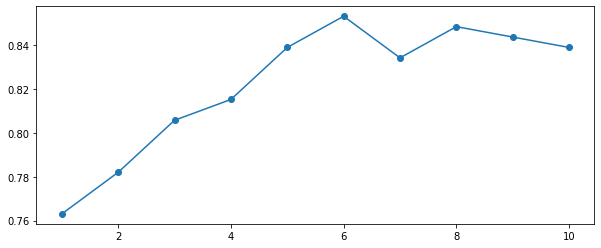

In [23]:
plt.figure(figsize=(10,4))
score_arr = []
for i in range(1,11):
    clf_tree = DecisionTreeClassifier(max_depth=i, random_state = 1)
    clf_tree.fit(X_train, y_train)
    y_pred = clf_tree.predict(X_test)
    score_arr.append(accuracy_score(y_test, y_pred))
plt.scatter([x for x in range(1,11)], score_arr)
plt.plot([x for x in range(1,11)], score_arr)

Apparantely, it seems `max_depth=6` is the current best choice for us, as it gives the highest accuracy. It's time to evaluate the influence of other parameters, starting with `max_features`. Empirically speaking for wide datasets the value should be from a quarter to half the number of columns. Let's check if it'll work for us.

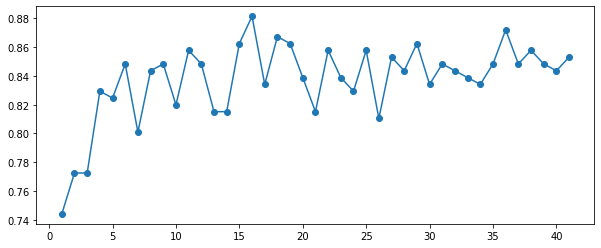

In [24]:
plt.figure(figsize=(10,4))
score_arr = []
for i in range(1,42):
    clf_tree = DecisionTreeClassifier(max_depth=6, max_features=i, random_state = 1)
    clf_tree.fit(X_train, y_train)
    y_pred = clf_tree.predict(X_test)
    score_arr.append(accuracy_score(y_test, y_pred))
plt.scatter([x for x in range(1,42)], score_arr)
plt.plot([x for x in range(1,42)], score_arr)

In our case the optimum value of `max_features` is 16. Last but not least let's take a look at the `min_samples_leaf` parameter. The higher the value, the less flexible the classes the tree will be, what should lead to accuracy decreasing

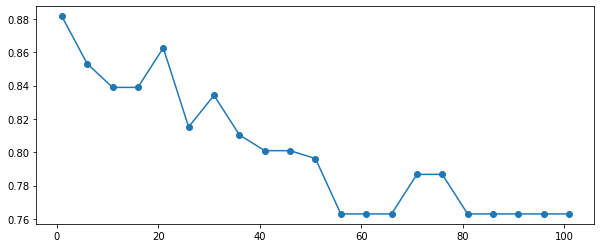

In [25]:
plt.figure(figsize=(10,4))
score_arr = []
for i in range(21):
    clf_tree = DecisionTreeClassifier(max_depth=6, max_features=16, min_samples_leaf=i*5+1, random_state = 1)
    clf_tree.fit(X_train, y_train)
    y_pred = clf_tree.predict(X_test)
    score_arr.append(accuracy_score(y_test, y_pred))
plt.scatter([x*5+1 for x in range(21)], score_arr)
plt.plot([x*5+1 for x in range(21)], score_arr)

As we predicted, the accuracy almost lineary decreases with increasing `min_samples_leaf` parameter. In produciton, I'd consider using the bump near `min_samples_leaf=20`, if there was a need in decreasing `max_depth`. <br>Our today's winner is `DecisionTreeClassifier(max_depth=6, max_features=16)` tree. Of course, it's still not the optimum tree. You have better chance finding it using grid search, whereas we used gradient. And don't forget about cross-validation - but that's a subject of another lesson

In [26]:
clf_tree = DecisionTreeClassifier(max_depth=6, max_features=16, min_samples_leaf=1, random_state = 1)
clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[123  17]
 [  8  63]]
              precision    recall  f1-score   support

         NRB       0.94      0.88      0.91       140
          RB       0.79      0.89      0.83        71

    accuracy                           0.88       211
   macro avg       0.86      0.88      0.87       211
weighted avg       0.89      0.88      0.88       211



### Feature importance 

One of the biggest advantages of using Trees is ability to interpretate results. Let's check, what features are most important for our classification

(36, 0.34651590837488355)
(39, 0.11689646986366699)
(34, 0.07256750296139453)
(6, 0.0710185745441286)
(12, 0.06446141139337126)


<BarContainer object of 41 artists>

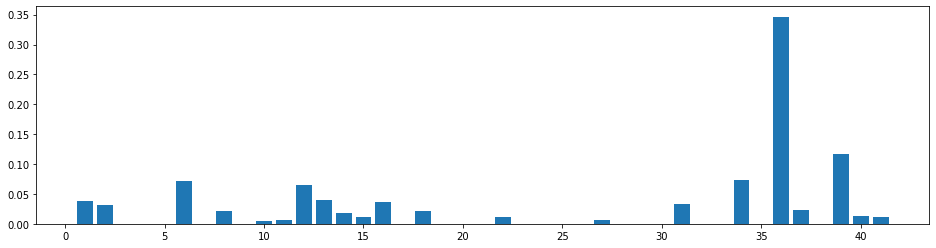

In [27]:
plt.figure(figsize=(16,4))
[print(x) for x in sorted(zip(X_train.columns,clf_tree.feature_importances_),key=lambda x:x[1],reverse=True)[:5]]
plt.bar(X_train.columns,clf_tree.feature_importances_)

So it seams *SpMax_B(m): Leading eigenvalue from Burden matrix weighted by mass (36)* and *SM6_B(m): Spectral moment of order 6 from Burden matrix weighted by mass (39)* play the biggest value in evaluating chemicals' biodegradability

## Decision Tree in a Regression Problem - Thermogravimetric Analysis

Decision Trees are not that often used as regression tools. The idea of a tree construction remains the same in case of predicting numeric variables. The quality criteria is different, though: 

$$\Large D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{j=1}^{\ell} y_j)^2, $$

where $\ell$ is the number of samples in a leaf, $y_i$ is the value of the target variable. Simplified, we look for features that divide the training set in such a way that the values of the target feature in each leaf are similar.

Let's look at real experimental data. As an example we'll study thermogravimetric analysis data from <a href = 'https://datadryad.org/stash/dataset/doi:10.5061/dryad.7q704rn'></a>https://doi.org/10.5061/dryad.7q704rn paper.
<br>*Cheng, K., Hu, J.P., Wu, Y.C., Shi, C.Q., Chen, Z.G., Liu, S.M., Yuan, Y.C., Mo, Y.Q. and Zhao, J.Q., 2019. Microwave-assisted synthesis of high thermal stability and colourless polyimides containing pyridine. Royal Society open science, 6(6), p.190196.*

In [28]:
tga_analysis = pd.read_excel('../../downloads/TGA-PIs.xlsx')

In this dataset we see, paired columns Temp - Mass loss for 4 compounds: PyDPM-PMDA, PyDPM-BPDA, PyDPM-ODPA, PyDPM-6FDA

In [29]:
tga_analysis.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,PyDPM-PMDA,NaN,NaN,PyDPM-BPDA,NaN,NaN,PyDPM-ODPA,NaN,NaN,PyDPM-6FDA,NaN
1,Temp./°C,Mass/%,NaN,Temp./°C,Mass/%,NaN,Temp./°C,Mass/%,NaN,Temp./°C,Mass/%
2,30.991,100,NaN,31.963,100,NaN,31.087,100,NaN,31.013,100
3,31.8289,99.8056,NaN,32.8009,99.4237,NaN,31.9249,99.7839,NaN,31.8509,99.8453
4,32.6668,99.7872,NaN,33.6388,99.5187,NaN,32.7628,99.7678,NaN,32.6888,99.8522


Let's make the dataset more readable and write several processing functions:

In [30]:
tga_analysis

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,PyDPM-PMDA,NaN,NaN,PyDPM-BPDA,NaN,NaN,PyDPM-ODPA,NaN,NaN,PyDPM-6FDA,NaN
1,Temp./°C,Mass/%,NaN,Temp./°C,Mass/%,NaN,Temp./°C,Mass/%,NaN,Temp./°C,Mass/%
2,30.991,100,NaN,31.963,100,NaN,31.087,100,NaN,31.013,100
3,31.8289,99.8056,NaN,32.8009,99.4237,NaN,31.9249,99.7839,NaN,31.8509,99.8453
4,32.6668,99.7872,NaN,33.6388,99.5187,NaN,32.7628,99.7678,NaN,32.6888,99.8522
...,...,...,...,...,...,...,...,...,...,...,...
910,791.819,69.4824,NaN,792.791,66.339,NaN,791.915,61.8845,NaN,791.841,63.1398
911,792.657,69.475,NaN,793.629,66.3226,NaN,792.753,61.8778,NaN,792.679,63.1394
912,793.495,69.4612,NaN,794.467,66.3012,NaN,793.591,61.8637,NaN,793.517,63.1246
913,794.332,69.4458,NaN,795.304,66.2849,NaN,794.428,61.8482,NaN,794.354,63.1138


In [31]:
tga_analysis.columns = list(['Temperature','Mass','empty']*4)[:11]
tga_analysis.drop(['empty'], axis=1, inplace=True)
tga_analysis = tga_analysis[2:-1].reset_index(drop=True)

#as we have 4 samples, i is in range[1:4]
def get_tg_sample(i):
    return tga_analysis.iloc[:,i*2-2:i*2].fillna(0)

def calculate_DTG(df):
    df['DTG'] = (df['Mass'].shift()-df['Mass'])
    return df

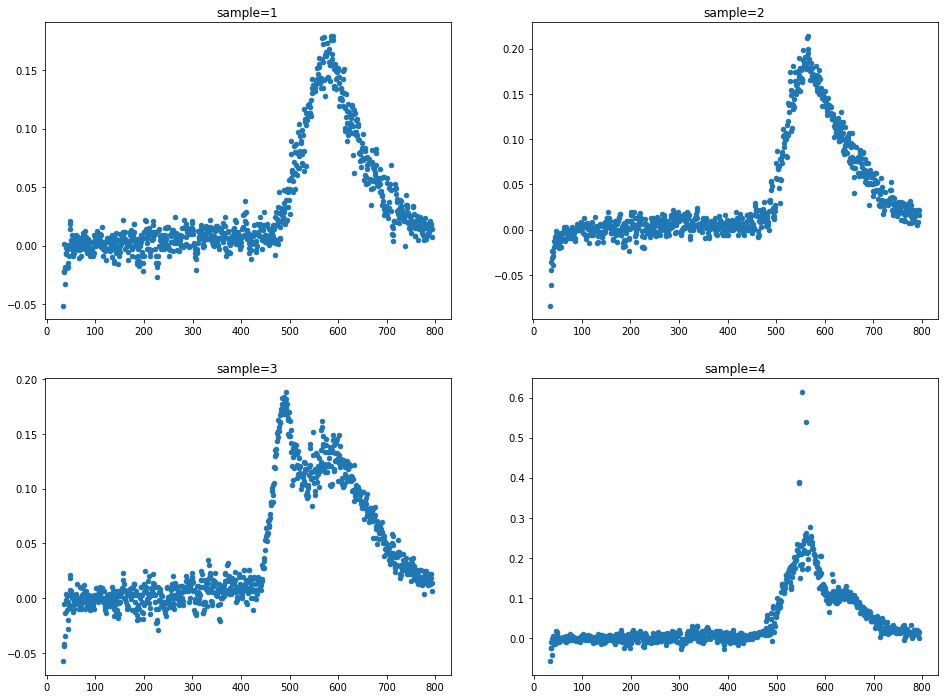

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16,12))
for i in range(4):
    tg_df = calculate_DTG(get_tg_sample(i+1))[3:-1].reset_index(drop=True)
    axes[i//2,i%2].scatter(tg_df['Temperature'], tg_df['DTG'], s=20)
    axes[i//2,i%2].set_title('sample={0}'.format(i+1))

Yep, looks like typical DTG curves. We can see, that for sample 1 and 2 we notice 1 peak, whereas for sample 3 and 4 more likely two peaks. Next we'll now compare our tree regressor with gaussian fitting curve. But only after removing noisy data in sample 4 with simple value filtering.

In [33]:
def remove_noise(df):
    return df[df['DTG'] < 0.3]

In [34]:
from scipy.optimize import curve_fit

# The following functions are used for fitting. You are welcome to understand what's behind them.
def gaussian(x, A, x0, sig):
    return A*np.exp(-(x-x0)**2/(2*sig**2))

def multi_gaussian(x, *pars):
    offset = pars[-1]
    g1 = gaussian(x, pars[0], pars[1], pars[2])
    g2 = gaussian(x, pars[3], pars[4], pars[5])
    g3 = gaussian(x, pars[6], pars[7], pars[8])
    return g1 + g2 + g3 + offset

guess = [\
         0, 480, 20,   \
         0.1, 700, 20, \
         0.1, 550, 20  \
        ]

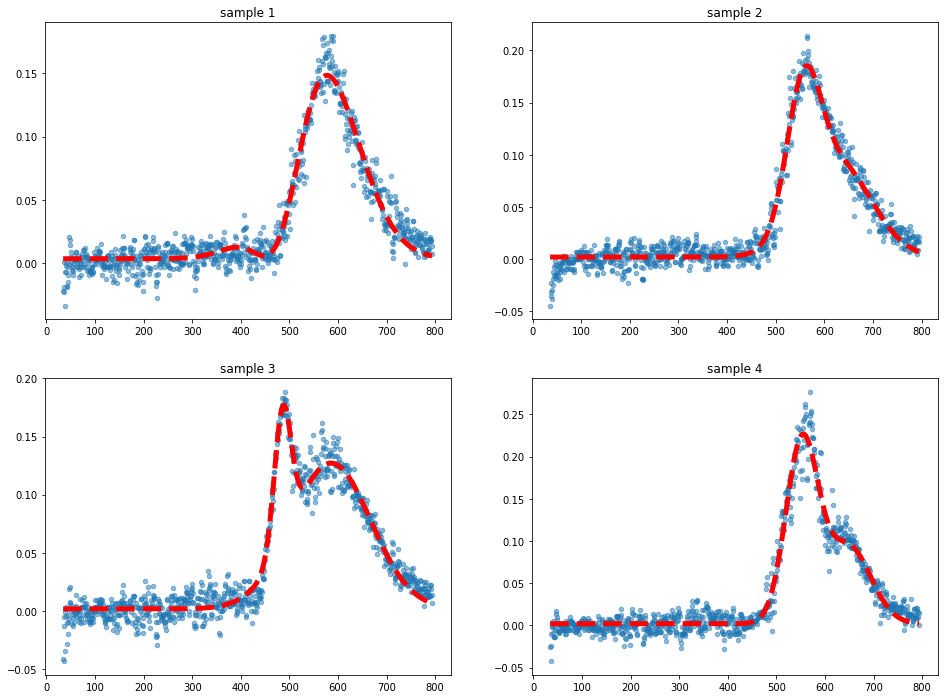

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16,12))
for i in range(4):
    tg_df = remove_noise(calculate_DTG(get_tg_sample(i+1)))[3:-1].reset_index(drop=True)
    X = tg_df['Temperature'].to_numpy()
    y = tg_df['DTG'].to_numpy()
    popt, pcov = curve_fit(multi_gaussian, X, y, guess)
    axes[i//2,i%2].scatter(X, y, s=20, alpha=0.5)
    axes[i//2,i%2].plot(X, multi_gaussian(X, *popt), 'r--', linewidth=5)
    axes[i//2,i%2].set_title('sample {0}'.format(i+1))

Pretty solid. We can now compare the curves to our tree classifiers. The reason why we didn't show scatter dots, gaussian curve and multiple tree classifiers on one plot is because the plot becomes super messy. 
<br>Among all samples, `sample 3`looks most interesting, so we'll describe it, with the [`sklearn.tree.DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). You can run other samples yourself.

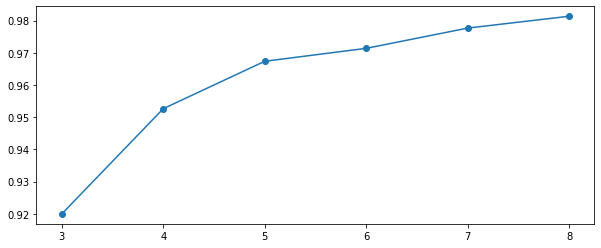

In [36]:
from sklearn.tree import DecisionTreeRegressor
plt.figure(figsize=(10,4))

sample_id = 3

tg_df = remove_noise(calculate_DTG(get_tg_sample(sample_id)))[3:-1].reset_index(drop=True)
X = tg_df['Temperature'].to_numpy()
y = tg_df['DTG'].to_numpy()
popt, pcov = curve_fit(multi_gaussian, X, y, guess)

reg_tree_pred = [0 for i in range(6)]
score_arr = [0 for i in reg_tree_pred]
for i in range (len(reg_tree_pred)):
    reg_tree = DecisionTreeRegressor(max_depth=i+3, random_state=17)
    reg_tree.fit(X.reshape(-1, 1), y)
    reg_tree_pred[i] = reg_tree.predict(np.linspace(X.min(), X.max(), X.shape[0]).reshape(-1, 1))
    score_arr[i] = reg_tree.score(X.reshape(-1, 1), y)

plt.scatter([x+3 for x in range(len(reg_tree_pred))], score_arr)
plt.plot([x+3 for x in range(len(reg_tree_pred))], score_arr)

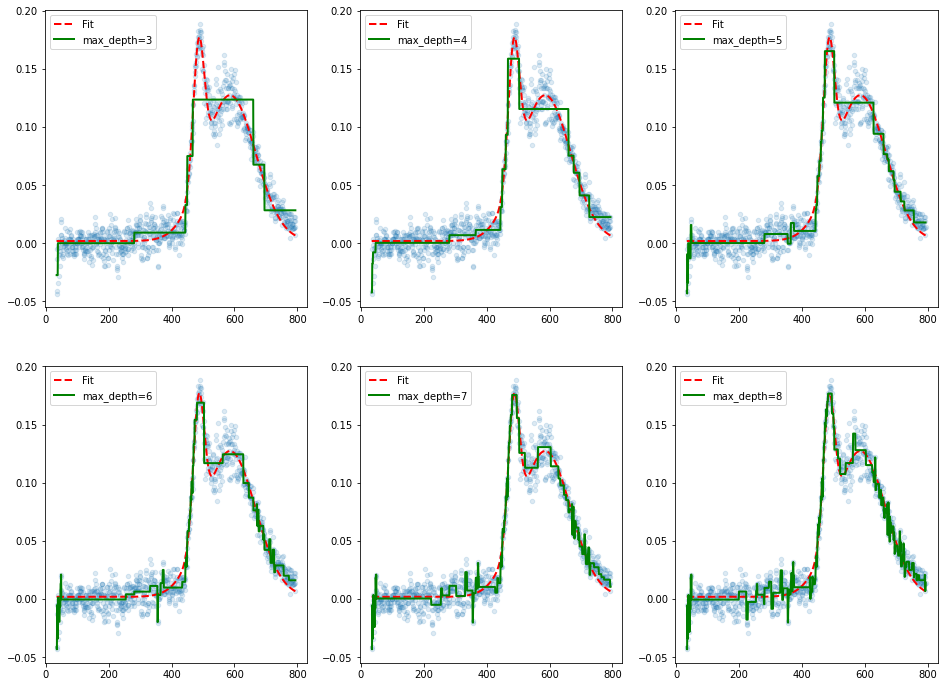

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(16,12))
for tree in enumerate(reg_tree_pred):
    axes[tree[0]//3,tree[0]%3].scatter(X, y, s=20, alpha=0.15)
    axes[tree[0]//3,tree[0]%3].plot(X, multi_gaussian(X, *popt), 'r--', linewidth=2, label='Fit')
    axes[tree[0]//3,tree[0]%3].plot(np.linspace(X.min(), X.max(), X.shape[0]).reshape(-1, 1), tree[1], label='max_depth={0}'.format(tree[0]+3), linewidth=2, color='g')
    axes[tree[0]//3,tree[0]%3].legend(loc="upper left")

As we can see from the score plot, the optimum `max_depth=5`, although the second peak is seen only after `max_depth=6`. One of the biggest challenges of using decision tree regressor is to overcome inflexibility, that curves give you.

# Conclusion

Pros:
- Decision Trees is a highly interpretabile model as the result is quite easy to understand.
- Decision trees can be easily visualized.
- Fast training and forecasting.
- Small number of model parameters.
- Supports both numerical and categorical features.

Cons:
- Trees are sensitive to any type of noise in the input data. Such unstable behaviour may lead to whole new model if the training set is slightly modified. This impairs interpretability of the model.
- Low quality and limitations of the separating border - the hyperplanes are perpendicular axes.
- The optimal decision tree search problem is NP-complete. One may use 'greedy' search algorithms, but it does not guarantee you'll find the globally optimal tree.
- Difficult to handle missing data.

## Appendix

### Gini uncertainty

Entropy:
<br>$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})};$
<br><br>Gini:
<br>$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+).$

In [39]:
def calculate_gini(a,b):
    return 2*a*b/(a+b)/(a+b)

In [40]:
_G0 = calculate_gini(metal_df[metal_df['is_metal'] == 0].shape[0], metal_df[metal_df['is_metal'] == 1].shape[0])
metal_df['g1'] = metal_df.iloc[:-1].apply(lambda x:calculate_gini(x.sum_metal, x.sum_non_metal), axis=1)
metal_df['g2'] = metal_df.iloc[:-1].apply(lambda x:calculate_gini(_ms-x.sum_metal, _nms-x.sum_non_metal), axis=1)
metal_df['dG'] = _G0 - metal_df['position']/_count*metal_df['g1'] - (_count-metal_df['position'])/_count*metal_df['g2']
_G0

0.49744897959183676

Max information gain at position 18


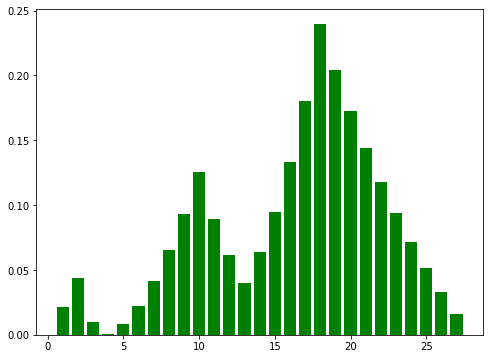

In [41]:
plt.figure(figsize=(8,6))
plt.bar(metal_df['position'], metal_df['dG'], color = 'green')

print('Max information gain at position {0}'.format(int(metal_df.loc[metal_df['dG'].idxmax(axis = 0)]['position'])))
plt.show()

Basically, Gini and Entropy gives you quite similar predictions. You can read more in the [`comparison paper`](https://www.unine.ch/files/live/sites/imi/files/shared/documents/papers/Gini_index_fulltext.pdf). The most important conclusions are:
- It only matters in about 2% of the cases whether you use gini impurity or entropy
- Entropy might be a little slower to compute (because it makes use of the logarithm)
- Gini is to minimize misclassification, whereas Entropy penalises small probabilities


## Additional links:

https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use